This is the first article in a series about at least one way to encode many-body quantum mechanics in python (and eventually Haskell too maybe). Why even do this? I think that understanding in principle how to encode the problem concretely into a computer let's you have a deeper understanding of what the hell is going on.

We're not winning any awards for speed or efficiency here. Intentionally. A low level formulation of all this in C using GPU acceleration or something would be significantly less understandble. Let us unshackle ourselves from too many considerations of efficiency.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

So to start, let's take a few moments to talk a very tiny bit about single body quantum mechanics. 

It is customary in solid state physics for the purposes of clarification to build simplified models of materials. One simplification is to say that electrons can exist on a lattice of sites with onsite energy $\epsilon$ and tunneling energy $t$. This lattice ultimately corresponds back to the crystal lattice of actual atoms and these mystery parameters can be related back closer (but not entirely. There really are huge gaps of deduction in our understanding of the chain of physics from the most fundamental to the large) to first principles by considering the Hamiltonian matrix elements $<\psi_m|H|\psi_n>$ of orbital wavefunctions of the atoms. Parametrizing the simplified model this way lets us cut a Gordian knot of complexity. For more info check out https://en.wikipedia.org/wiki/Tight_binding.

For simplicity, let's consider a periodic 1-d ring of sites. This is convenient programmatically and mathematically. We can then extend this to greater and greater realism by the inclusion of more realtstic boundaries or try to physically realize such 1-d models in reality using nanowires or other somewhat exotic things.

A wavefunction $\psi$ with the particle sitting on the 0th site can be written like so

[ 1.  0.  0.  0.  0.  0.]


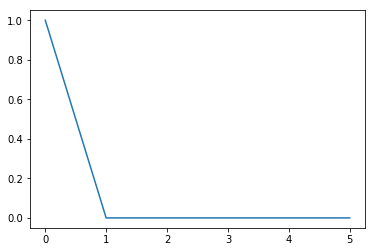

In [2]:
NSites = 6
psi = np.zeros(NSites)
psi[0] = 1
print(psi)
plt.plot(psi)

Now let's build the simple Hamiltonian as an explicit matrix acting on these wavefunctions. The Hamiltonian has the interpetation of giving the possible energies of the particle, but it is also useful as a way of thinking about where states go under time evolution. Any nonzero element $h_{ij}$ is a connection between site i and j. The tunneling element $t$ connects nearest neighbor sites.

The periodic nature of the Hamiltonian makes it useful to use the circulant matrix construction function from scipy. 

In [3]:
from scipy.linalg import circulant

eps = 1.0
t = 0.5

firstcol = np.zeros(NSites)
firstcol[0] = eps
firstcol[1] = t
firstcol[-1] = t

oneH = circulant(firstcol) #Takes first column and repeats it shifted
print(oneH)

[[ 1.   0.5  0.   0.   0.   0.5]
 [ 0.5  1.   0.5  0.   0.   0. ]
 [ 0.   0.5  1.   0.5  0.   0. ]
 [ 0.   0.   0.5  1.   0.5  0. ]
 [ 0.   0.   0.   0.5  1.   0.5]
 [ 0.5  0.   0.   0.   0.5  1. ]]


It is then simple to ask for the energy (eigenvalues) levels of the matrix, or apply it to a wavefunction (which may be part of a single time step for example).

[ 1.-0.1j   0.-0.05j  0.+0.j    0.+0.j    0.+0.j    0.-0.05j]


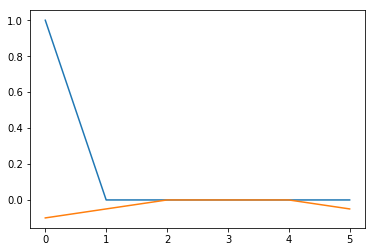

In [4]:
dt = 0.1 # a discretized time step dt.
I = np.eye(NSites) #identity matrix
psi1 = (I - 1.j * dt * oneH) @ psi #@ is python3 notation for matrix product. I like it.
print(psi1)
plt.plot(np.real(psi1))
plt.plot(np.imag(psi1))

After that, let's switch gears a bit.

A first approach to many-body quantum mechanics is the occupation number representation. The states are labelled by a binary string, with 1s corresponding to filled states and 0s to empty states. For example the binary string 0b010001 would have a particle sitting on the 0th and the 4th site and empty everywhere else. Since you will need 1 bit per site, the total size of the vector space is $2^{\# Sites}$. To label the states we'll need a couple of bit twiddling tricks.

A common idiom for getting a bit string with the nth bit set is to bit shift a 1 over by n.

In [5]:
bin(1 << 3)

'0b1000'

You mix strings with the or operator |

In [6]:
n = 1 << 3 | 1 << 4
print(bin(n))

0b11000


One way to count the number of bits set to one (the total occupation number of the lattice) is to use the following pythony code.

In [7]:
bin(n).count("1")

2

However it will be nice to use another method. The Wikipedia article for [Hamming Weight](https://en.wikipedia.org/wiki/Hamming_weight) (a name for the operation of counting 1s in a binary string) has this code for a 64-bit unsigned integers. This is slightly inflexible and worrisome, however 64 sites using the methodology we're using is totally impossible, so we might be okay. We'll need to be careful in the future to cast as uint64 or we'll get awful bugs unfortunately. This code vectorizes into numpy arrays.

In [8]:
#from wikipedia article on hamming weight
# works for 64 bits numbers

m1  = 0x5555555555555555; #binary: 0101...
m2  = 0x3333333333333333; #binary: 00110011..
m4  = 0x0f0f0f0f0f0f0f0f; #binary:  4 zeros,  4 ones ...
m8  = 0x00ff00ff00ff00ff; #binary:  8 zeros,  8 ones ...
m16 = 0x0000ffff0000ffff; #binary: 16 zeros, 16 ones ...
m32 = 0x00000000ffffffff; #binary: 32 zeros, 32 one
hff = 0xffffffffffffffff; #binary: all ones
h01 = 0x0101010101010101;
def popcount64c(x):
    x -= (x >> 1) & m1;             #put count of each 2 bits into those 2 bits
    x = (x & m2) + ((x >> 2) & m2); #put count of each 4 bits into those 4 bits 
    x = (x + (x >> 4)) & m4;        #put count of each 8 bits into those 8 bits 
    return (x * h01) >> 56;  #returns left 8 bits of x + (x<<8) + (x<<16) + (x<<24) + ... 


Since 0 corresponds to the bit string 0b000000, this is the completely empty state, which we may call the vacuum. We need to set the amplitude of this index to 1.0 so that it accounts for the total quantum amplitude of being empty.

In [9]:
NSites = 6
NStates = 2 ** NSites

def vac(NStates):
    state = np.zeros(NStates)
    state[0] = 1.0
    return state

Now we get to the meat. How do we implement fermionic creation and annihilation operators commonly denoted $a_j^\dagger$ and $a_j$. The operators when applied to a state fill (create a particle) at an empty spot at site $j$, or empty it (annihilate the particle).
There is some truly funky business with fermions that we have to anticommute these operators. This is part of the mathematical origin of the Pauli Exclusion principle and has some relation to determinants, which we will see an aspect of later. Don't get me wrong. These minus signs are weird.
To account for them, we pick a canonical ordering for the creation operators, in our case in descending order, for example $a_6^\dagger a_3^\dagger a_0^\dagger |0>$. We only need anti-commute sufficiently to get an operator into it's canonical position in the expression representing the state for example $a_3^\dagger a_6^\dagger a_5^\dagger a_4^\dagger a_0^\dagger |0> = - a_6^\dagger a_5^\dagger a_4^\dagger a_3^\dagger a_0^\dagger |0> $. 
It's complicated and it took me a couple tries to get the binary version of this right.

reshapeSite is a convenience function for reshaping the state vector so that the middle index is now specifying the filled or unfilled nature of site n.

In [10]:

def reshapeSite(site, state):
    #returns state reshaped as (leftstatechanges(msb), occupy/unoccupied, rightstatechanges(lsb))
    return state.reshape((-1, 2,2**site))

def adag(site, state, copy=True):
    if copy:
        state = np.copy(state)
    state = reshapeSite(site,state)
    state[:,1,:] = state[:,0,:] 
    state[:,0,:] = 0
    state = state.flatten()
    return antiCommuteFactor(site,state)

    





We haven't yet seen how to implement the anticommuting factor. This is where we need the Hamming weight function. We need to count the number of occupied states the the left of the particle (bits that are more significant than bit n). This is the number of adag operators we need to anticommute through to put the state into canonical ordering. 

In [11]:

def antiCommuteFactor(site, state):
    indices = np.arange(state.size, dtype=np.uint64)
    rightBinary = indices >> site + 1 # shift out all the bits to the right
    isOdd = popcount64c(rightBinary) & 0x1
    return np.where(isOdd, -1, 1) * state

I don't want to use a bare 'a' for the annihilation operator. I used agad. So sue me. Otherwise it is very similar to adag. 

In [12]:
def agad(site, state, copy=True):
    if copy:
        state = np.copy(state)
    state = reshapeSite(site,state)
    state[:,0,:] = state[:,1,:] #turns 1 into a zero
    state[:,1,:] = 0 #nothing comes into the occupied state
    state = state.flatten()
    return antiCommuteFactor(site,state)


Some other useful routines. A pretty printer avoids printing a bunch of zeros and puts it in bra ket notation.

In [13]:
def Num(site, state, copy=True):
    if copy:
        state = np.copy(state)
    state = reshapeSite(site,state)
    state[:,0,:] = 0 #zero out if unoccupied
    return state.flatten()

def prettyPrint(state,nsites):
    #avoids printing nearly zero, and puts in ket notation
    returnstr = ""
    for index,amp in enumerate(state):
        if abs(amp) > 0.001:
            returnstr += str(amp) + " * |" + bin(index)[2:].zfill(nsites) + "> + "
    return returnstr + "0"

Here we can see that alternate orderings of applying the operators give opposite signs out front.

In [14]:
state1 = adag(1,adag(0, vac(NStates)))
state2 = adag(0,adag(1, vac(NStates)))
print(prettyPrint(state1, NSites))
print(prettyPrint(state2, NSites))

1.0 * |000011> + 0
-1.0 * |000011> + 0


Now using these operators we could implement the application of a Hamiltonian fairly easily. We use the second quantized formulation of the single site Hamiltonian. The sum does it very every possible site.

In [15]:
def singleSiteH(i, state):
    eps = 1.0
    t = 0.5
    left = (i+1) % NSites #modulo NSites to make periodic
    return      eps * Num(i,state) + \
                t * adag(left, agad(i,state)) + \
                t * adag(i, agad(left,state))
    

def H0(state):
    return sum([singleSiteH(i,state) for i in range(NSites)])
        
        

Here we can compare the new way of applying H to the way at the beginning.

In [16]:
state = adag(0,vac(NStates))
print(prettyPrint((H0(state)), NSites))
print(oneH @ psi)

1.0 * |000001> + 0.5 * |000010> + 0.5 * |100000> + 0
[ 1.   0.5  0.   0.   0.   0.5]


It is now possible to consider the interparticle interactions thought. This is something really new. We can unpack the binary string to a list of positions where it has a 1.

In [17]:
def binaryToPositionList(occupation):
    pos = []
    for site in range(NSites):
        if (occupation >> site) & 0x1:
            pos.append(site)
            
    return pos

Given this position list it is striaghtforward to compute the energy of that configuration using a Coulomb $\frac{1}{r}$ potential for example.

In [18]:
def V(poslist):
    U = 0
    for i, pos1 in enumerate(poslist):
        for j in range(i):
            U += 1.0 / abs(pos1 - poslist[j])
    return U

In the occupation representation the potential V is actually a diagonal operator. This means we can use element wise multiplication to apply it.

In [19]:
def applyV(state):
     return np.array([V(binaryToPositionList(occ)) for occ in range(NStates)]) * state

We can try it out. Indeed the two particles have energy $\frac{1}{4}$

In [24]:
state = adag(4, adag(0,vac(NStates)))
prettyPrint(applyV(state), NSites)

'0.25 * |010001> + 0'

The total Hamiltonian is the sum of the single particle part and the interaction

In [22]:
def H(state):
    return H0(state) + applyV(state)

In [23]:
prettyPrint(H(state), NSites)

'0.5 * |000101> + 2.83333333333 * |001001> + 0.5 * |001010> + 2.75 * |010001> + 0.5 * |010010> + 0.5 * |100001> + -0.5 * |101000> + -0.5 * |110000> + 0'

There we go. That's a watershed moment!

Now, we've only given ourselves the power to apply linear operators. True dense representation of the matrices would allow us to ask for inverse and eigenvalues and things.
But we can also approach perturbation theory which is designed to use only easy operations like multiplication. We'll examine that in the next part.